In [1]:
"""
First created on July 30 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. TESTING_FOLDER will be filled during the run with images from the analysis 

3. (OPTIONAL) Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes somewhat large and possibly hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/tigress/ncaplar/PFS/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}


<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_27900/2166234586.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import Zernike_Module
from Zernike_Module import *
print(f'Zernike_Module.__version__: {Zernike_Module.__version__}')

import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import pickle
import logging

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy 
import scipy.misc

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
matplotlib.rcParams["figure.facecolor"] = "white"

print(f'np.__version__: {np.__version__}')
print(f'scipy.__version__: {scipy.__version__}')
print(f'pd.__version__: {pd.__version__}')

/tmp/ipykernel_27900/3632175713.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Zernike_Module.__version__: 0.52
np.__version__: 1.20.3
scipy.__version__: 1.8.1
pd.__version__: 1.4.2


## Single example with dummy values to check that the code  is working

Let's start with creating a test image on which we can demostrate some main features of the code. As such, we will create an image with dummy values and see how changing parameters changes how the model images look.

In [5]:
# Parameters that we are passing to algorithm
# Names of the variables are printed out in the next cell
# We will go through what some of the parameters do in the notebook below
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0,1,1,
                                 0.2,-0.0,0.92,0.08,0.8,
                                 1.06,0.28,
                                 50000,2.5,0.027,0.37,1.85,1.0])

# Here we initialize the class that creates a single image
# Parameters that needs to be passed are the science and variance image 
# In ``normal'' operation those would be the image taken with the spectrograph
# For purposes of this tutorial, lets just create some some dummy images
# That is why we create an array with filled the value of 1

# save = 1 instructs the algorithm to save on the hard drive the intermediate images

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
model = LN_PFS_single(sci_image=sci_image_unit,var_image=var_image_unit,save=1)   
res = model(allparameters_proposal,return_Image=True)

/projects/HSC/PFS/stack/20220525/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [6]:
# columns describing the names of the parameters used to create the images
columns = np.array(model.columns)
columns

array(['z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'detFrac',
       'strutFrac', 'dxFocal', 'dyFocal', 'slitFrac', 'slitFrac_dy',
       'wide_0', 'wide_23', 'wide_43', 'misalign', 'x_fiber', 'y_fiber',
       'effective_ilum_radius', 'frd_sigma', 'frd_lorentz_factor',
       'det_vert', 'slitHolder_frac_dx', 'grating_lines',
       'scattering_slope', 'scattering_amplitude', 'pixel_effect',
       'fiber_r', 'flux'], dtype='<U21')

# overview of the procedure 

## ilumination of the exit pupil

In this first section lets go over how the image is created in this algorithm. We first start with the image of the pupil, convolved with effects that change its illumination. Such effects include misaiming of the fiber, the fact that fiber illuminaton does not illuminate the whole pupil, and FRD (focal ratio degradation). We apply the wavefront description to this image and do FFT. This creates an image, which we convolve with the fiber profile, grating and detector effects to get the final image. 

Text(0.5, 1.0, '2d image of the pupil')

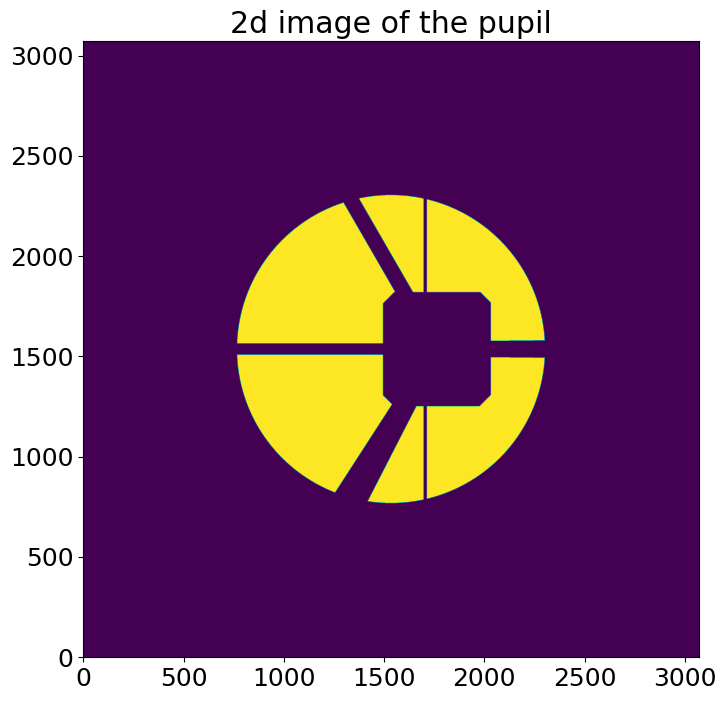

In [7]:
# this is the full pupil - just cutout of the pupil and all of the obstructions added - but without FRD and any other fiber effects

plt.figure(figsize=(8,8))
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy') 
plt.imshow(aperilluminated,origin='lower')
plt.title('2d image of the pupil')

Text(0.5, 1.0, '1d cut showing the illumination')

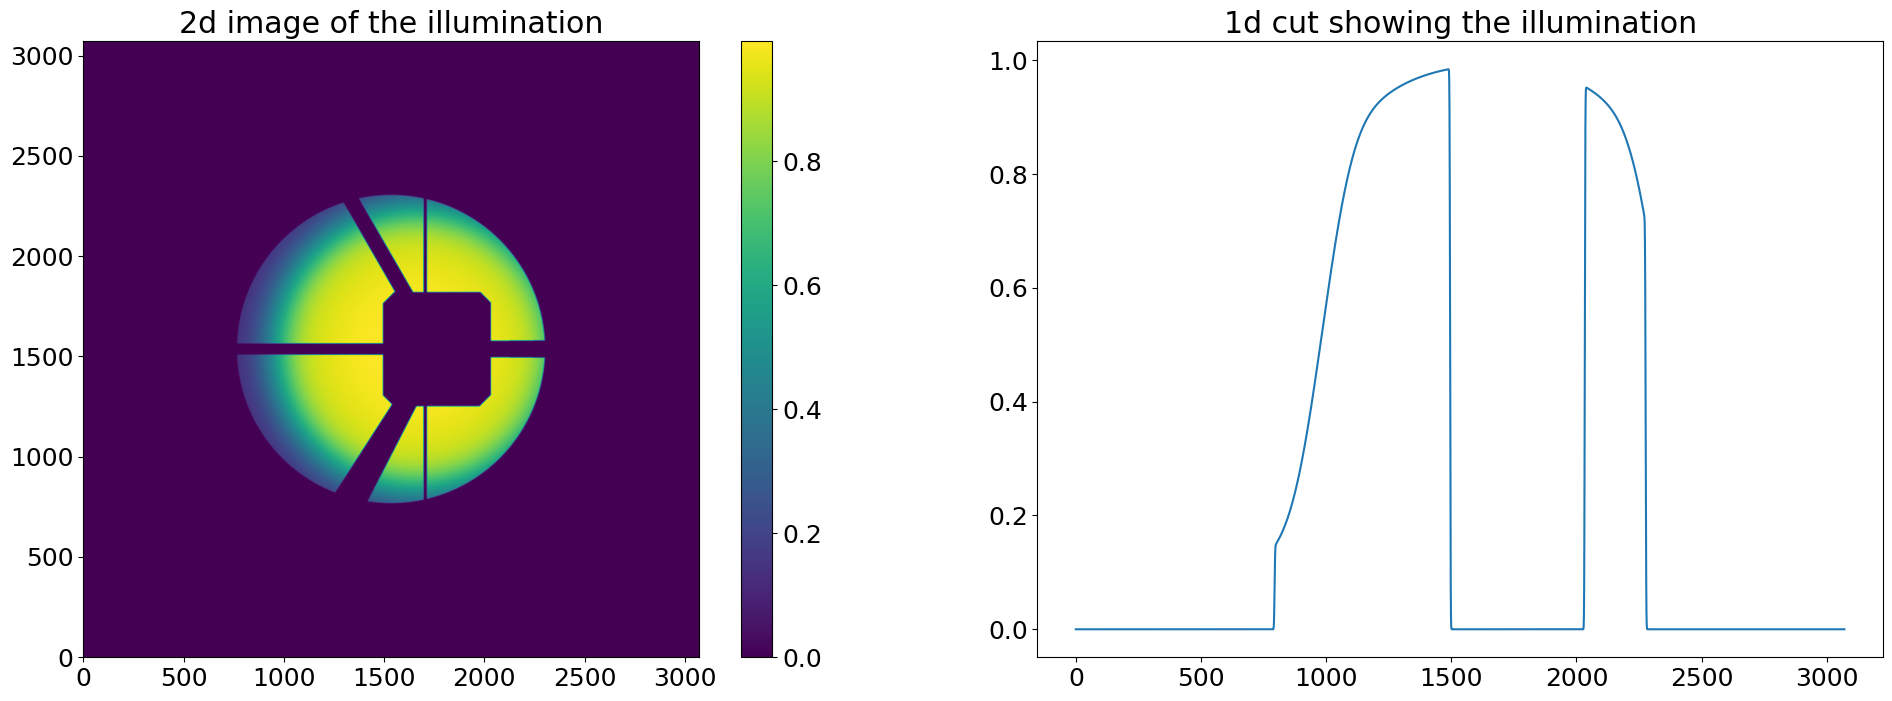

In [8]:
# image showing the pupil and its illumination 
# after we have included the implementation of the FRD (focal ratio degradation)

r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric_apodized.npy') 

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(r,origin='lower')
plt.colorbar()
plt.title('2d image of the illumination')

plt.subplot(122)
plt.plot(r[int(r.shape[0]/2+200)])
plt.title('1d cut showing the illumination')

## wavefront on the exit pupil

(3072, 3072)

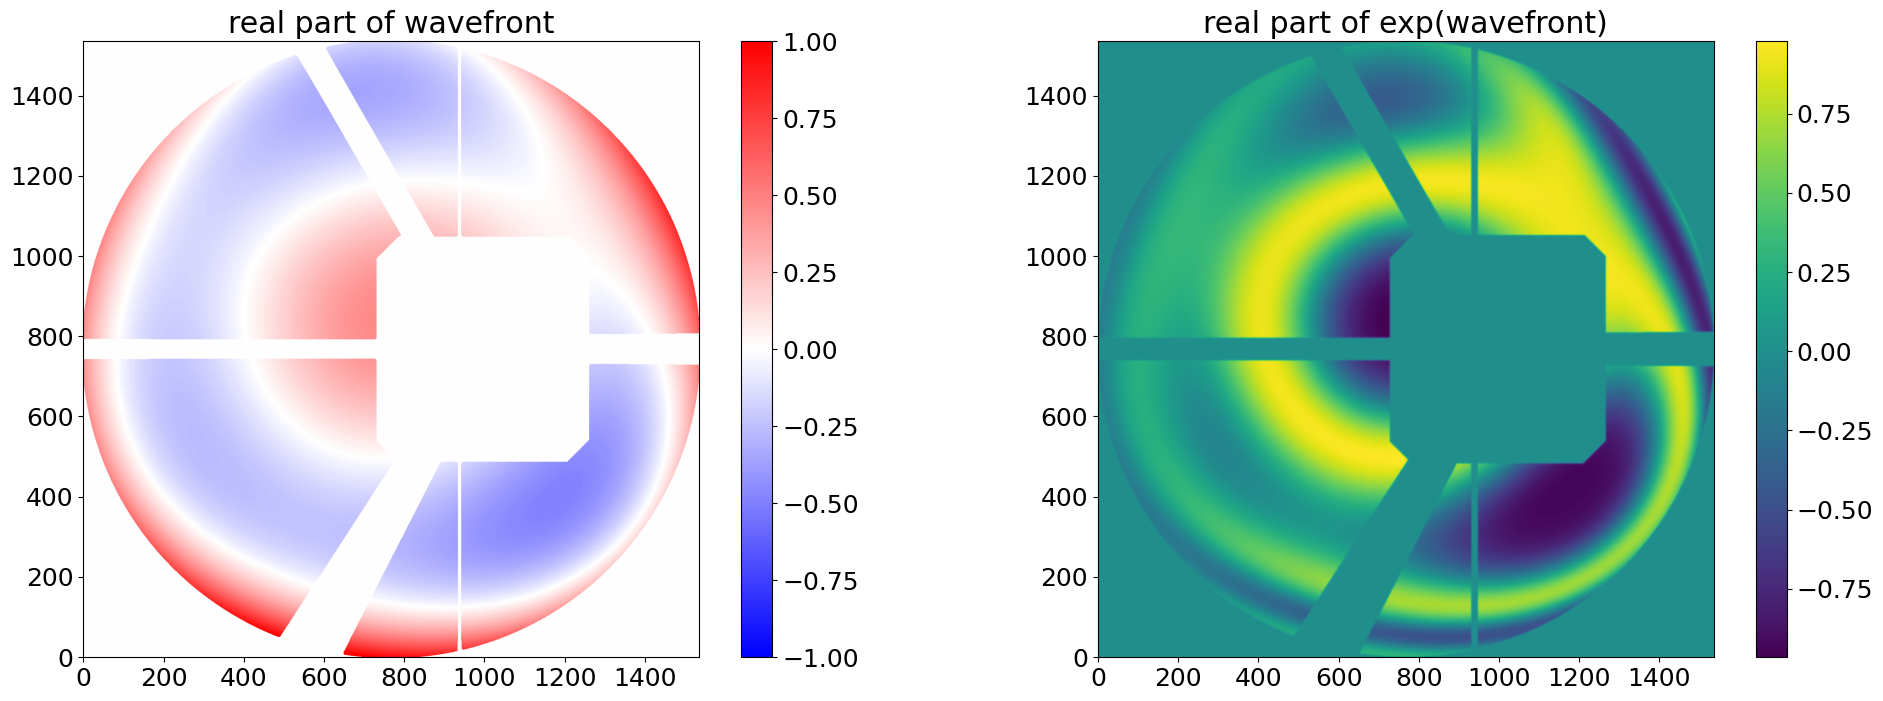

In [9]:
# wavefront which we apply to the pupil
# We zoom onto the central part of the image to better see the wavefront

wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')  

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(np.real(wf_grid)[768:768+1536,768:768+1536],origin='lower', cmap = 'bwr', vmin = -1 , vmax =1)
plt.title('real part of wavefront')
plt.colorbar()

plt.subplot(122)
plt.title('real part of exp(wavefront)')
plt.imshow(np.real(expwf_grid)[768:768+1536,768:768+1536],origin='lower')
plt.colorbar()
np.real(expwf_grid).shape

## single spot - images in real spot

Text(0.5, 1.0, 'result of FFT, zoomed in, linear scaling')

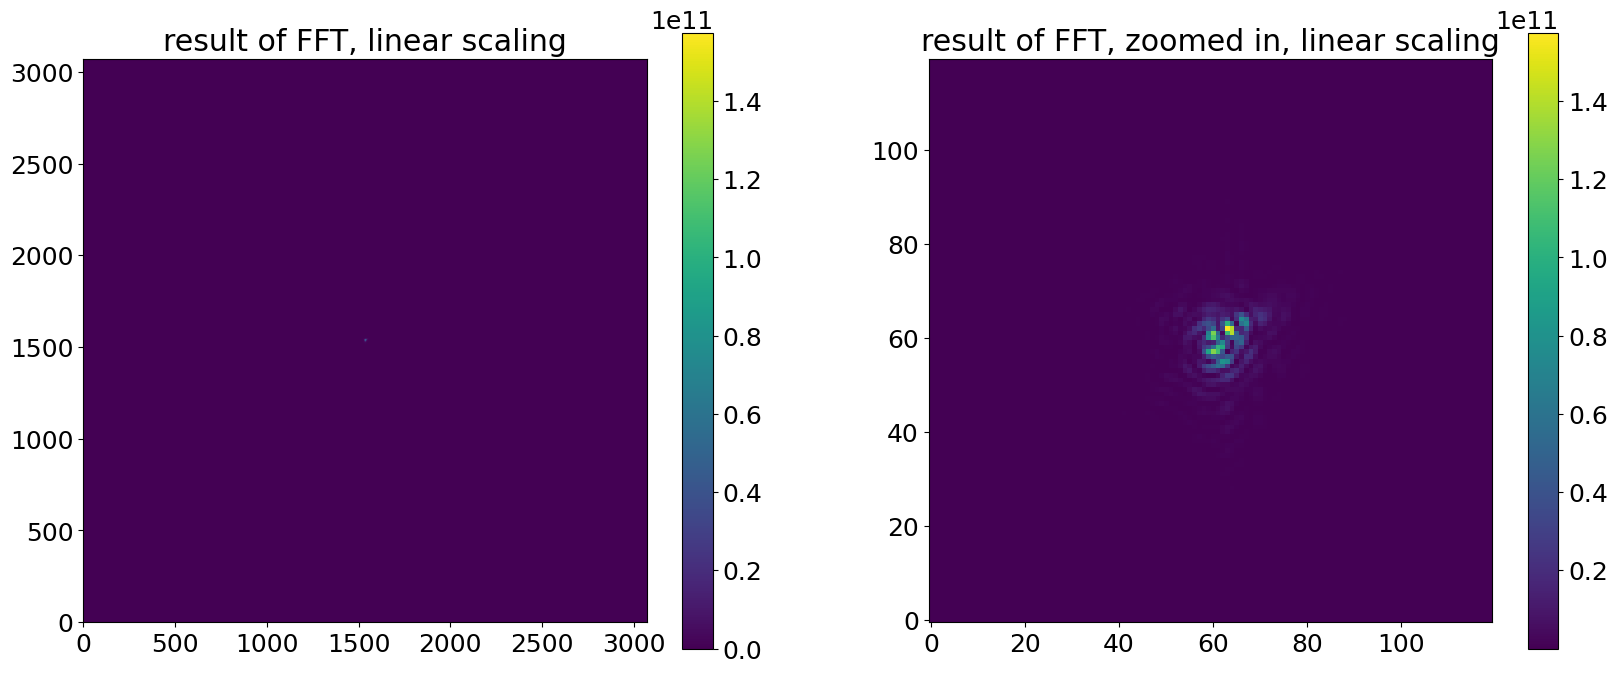

In [10]:
# The image after FFT 
# This is highly oversampled image, i.e., the resolution of the image is much higher than the resolution 
# of the pixels on the detector

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower')
middleposition=int(optPsf.shape[0]/2)
cbar=plt.colorbar()

plt.title('result of FFT, linear scaling')

plt.subplot(122)
plt.imshow(optPsf[middleposition-60:middleposition+60,middleposition-60:middleposition+60],origin='lower')
cbar=plt.colorbar()

plt.title('result of FFT, zoomed in, linear scaling')

Text(0.5, 1.0, 'result of FFT, zoomed in, log')

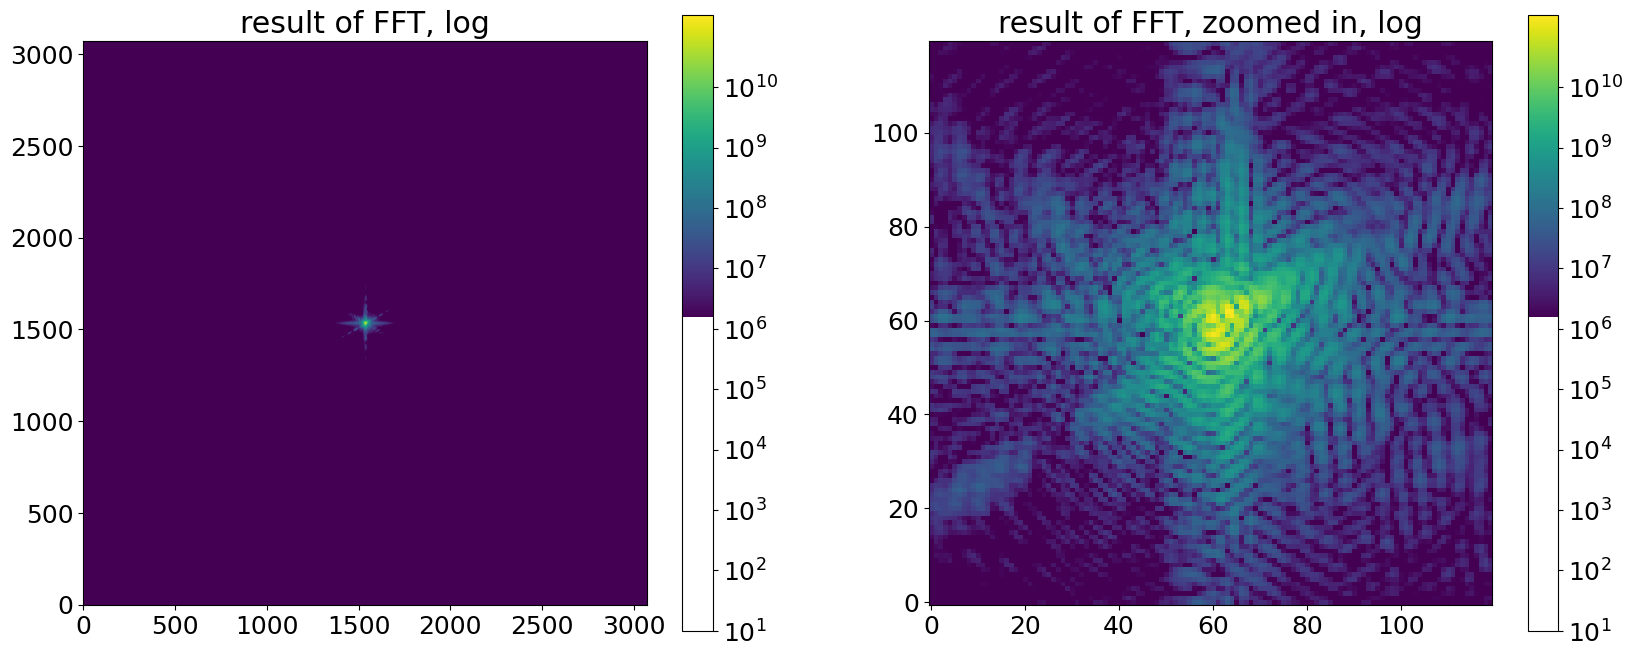

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-60:middleposition+60,middleposition-60:middleposition+60],origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## spot convolved with fiber 

Text(0.5, 1.0, 'spot convolved with fiber, zoomed in')

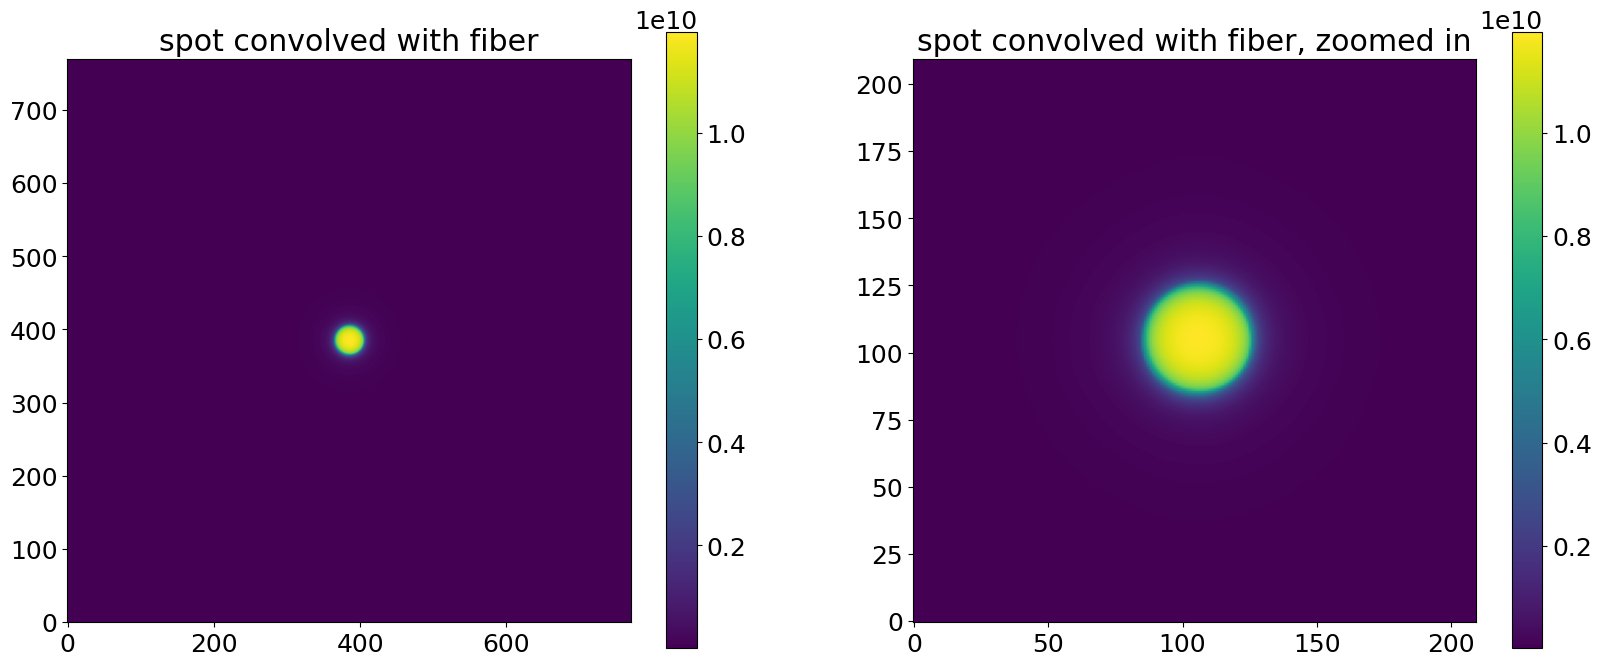

In [12]:
# The image created above gets convolved with the fiber 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')    
middleposition=int(optPsf_cut_fiber_convolved.shape[0]/2)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower')
plt.colorbar()
plt.title('spot convolved with fiber')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('spot convolved with fiber, zoomed in')

Text(0.5, 1.0, 'fiber convolved spot, zoomed in, log')

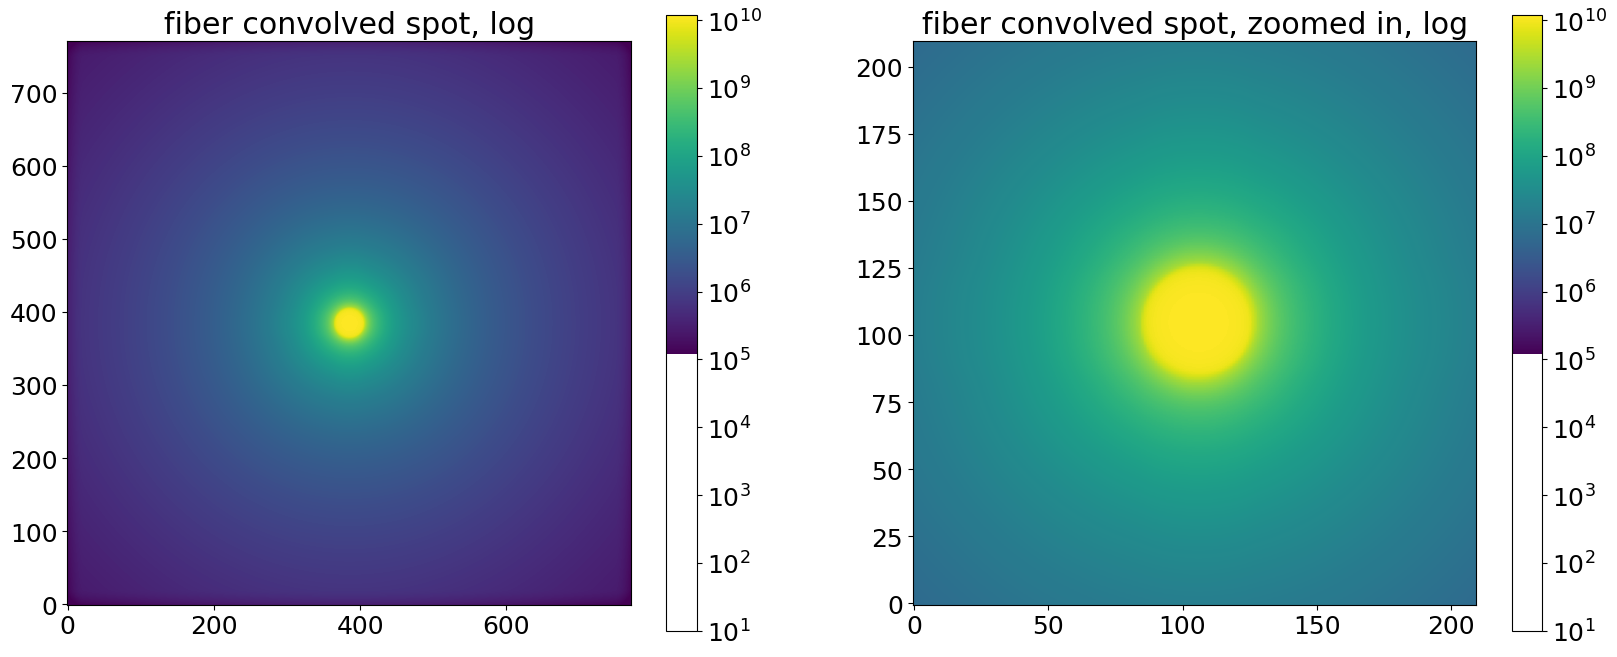

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower',norm=LogNorm(vmin=np.max(optPsf_cut_fiber_convolved)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, log')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(vmin=np.max(optPsf_cut_fiber_convolved)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, zoomed in, log')

## spot convolved with fiber and pixel reponse

Text(0.5, 1.0, 'fiber and pixel convolved spot, zoomed in')

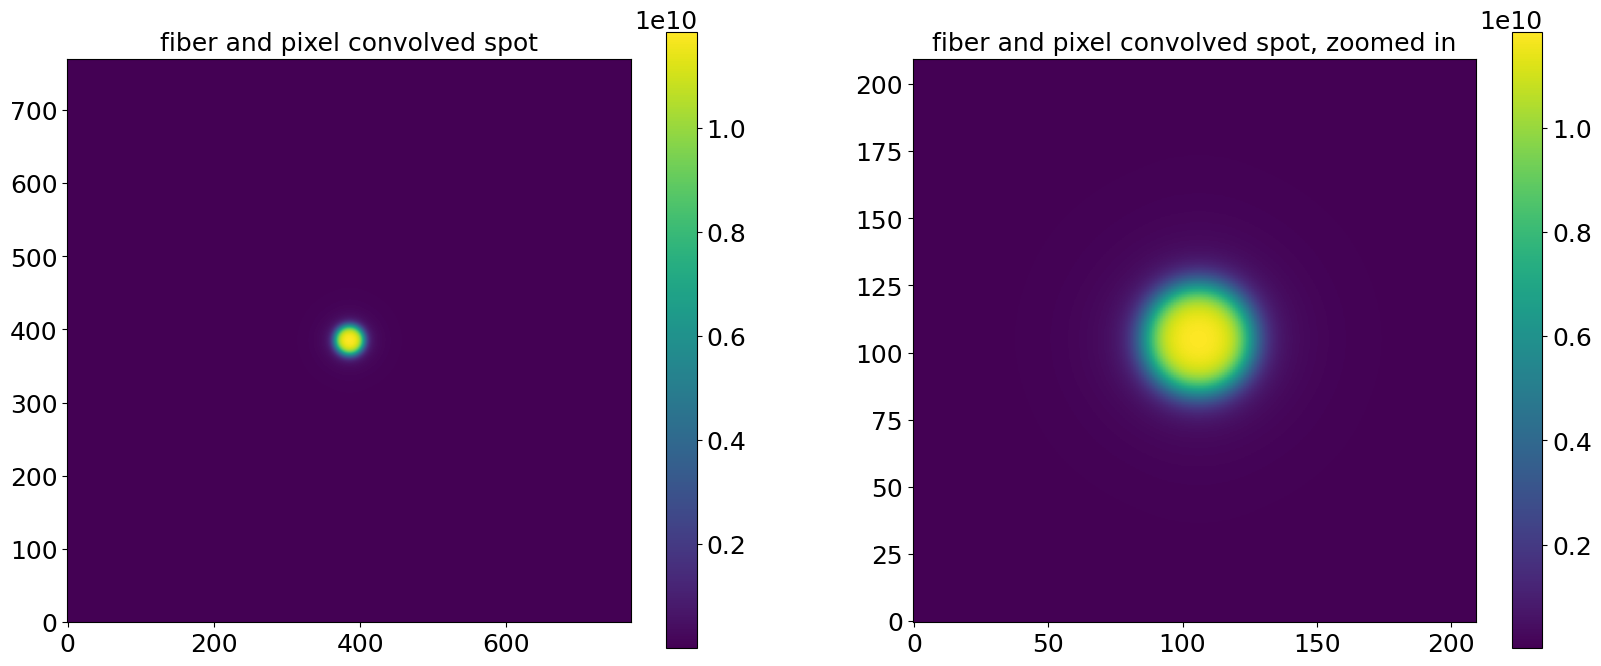

In [14]:
# We also convolve the image with ``detector response'', i.e., take into account the fact that there is diffusion of electrons as they get detected

optPsf_cut_pixel_response_convolve=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')   
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot, zoomed in', fontsize=18)

Text(0.5, 1.0, 'fiber and pixel convolved spot, zoomed in, log')

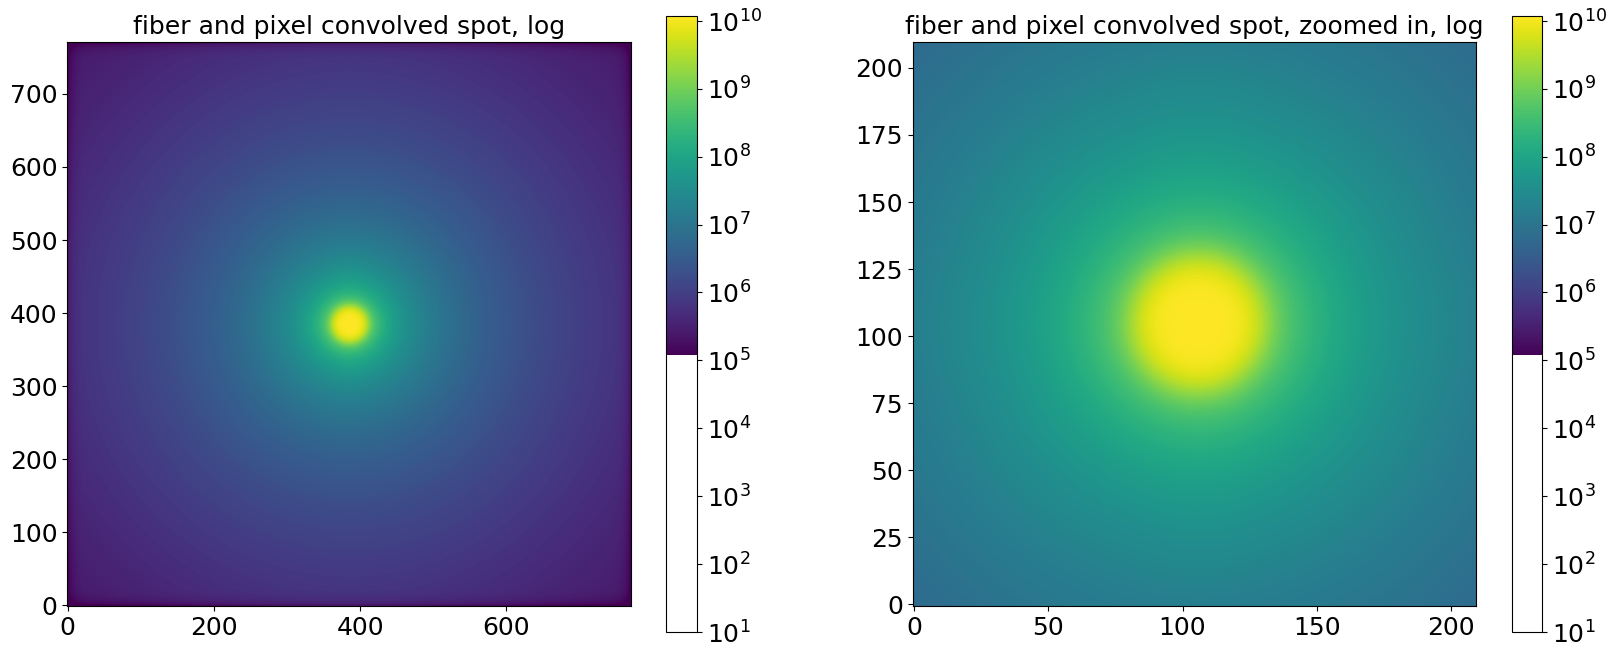

In [15]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower',norm=LogNorm(vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, log', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],
           origin='lower',norm=LogNorm(vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, zoomed in, log', fontsize=18)

## final result

Text(0.5, 1.0, 'final result, log scale')

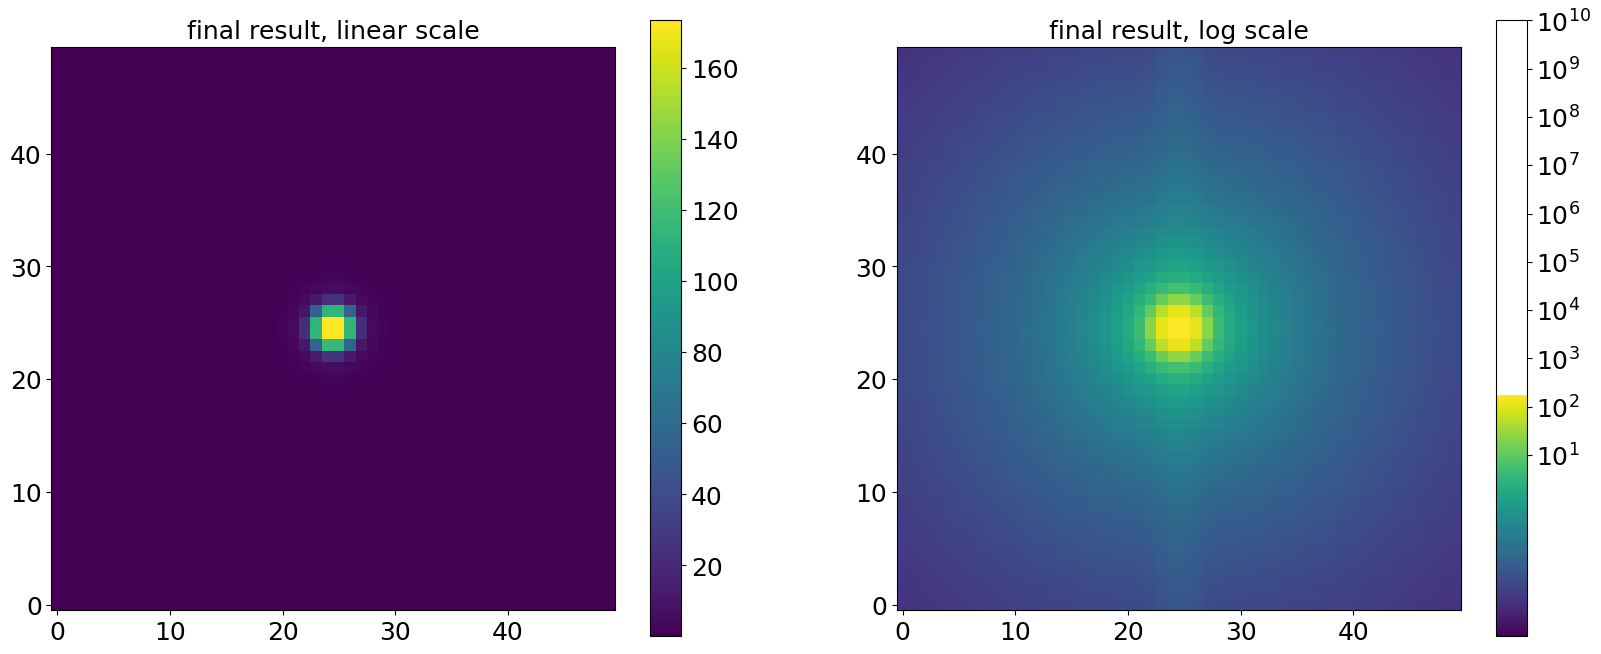

In [16]:
# We finally get to look at the final results, which has been scaled to look as it would appear on the detector

optPsf_final=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_final.npy')   

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_final,origin='lower')
plt.colorbar()
plt.title('final result, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_final,origin='lower',norm=LogNorm(vmin=np.max(optPsf_final)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result, log scale', fontsize=18)

Text(0.5, 1.0, 'final result  with noise, log scale')

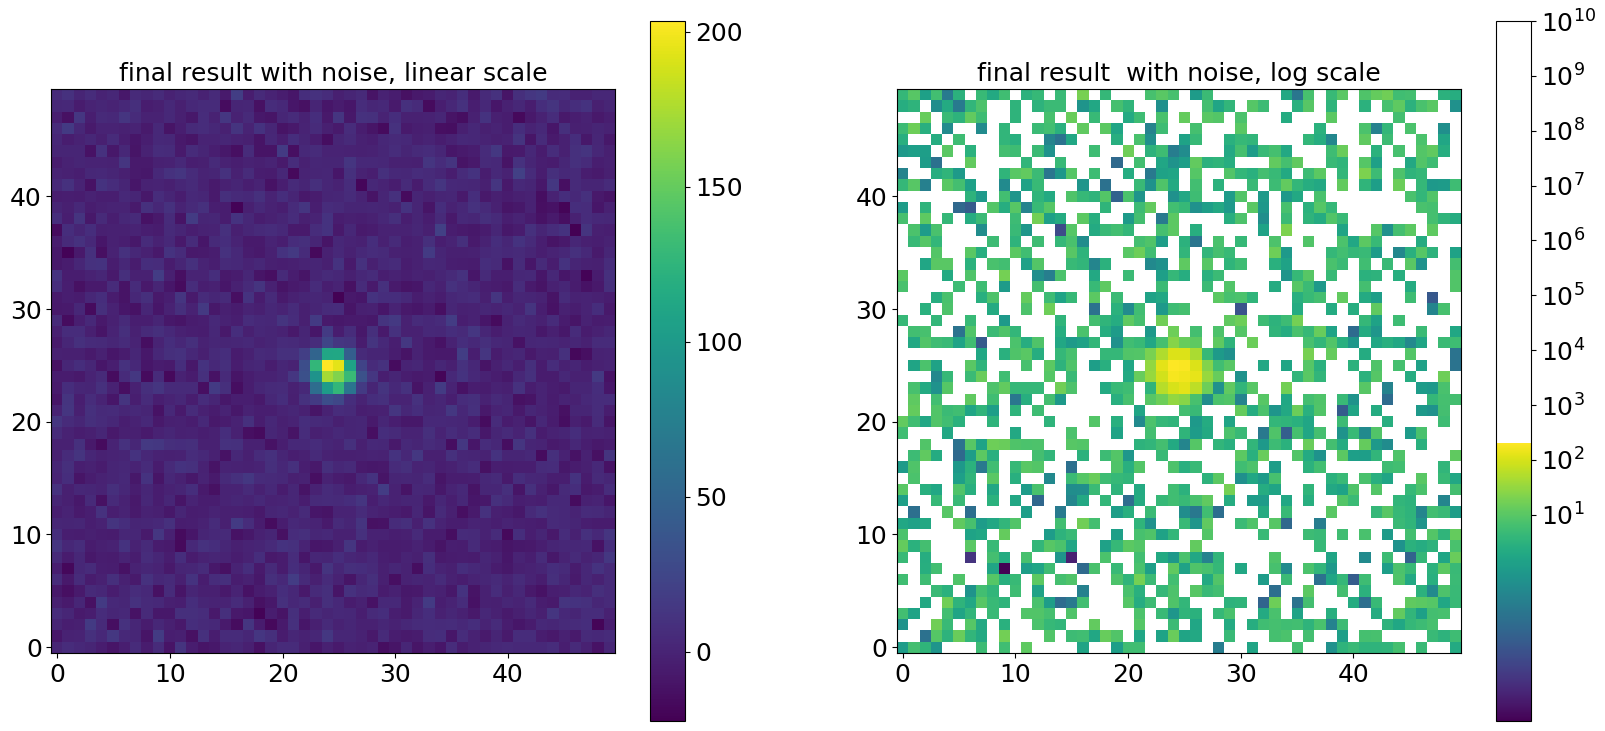

In [17]:
# this part adds noise to the perfect models

# as a very simplified model, assume that the variance images is the same as the science image + some read noise 
var_image=optPsf_final+40

artifical_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
for i in range(len(artifical_noise_data)):
    for j in range(len(artifical_noise_data)):
        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
        

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf_final+artifical_noise_data,origin='lower')
plt.colorbar()
plt.title('final result with noise, linear scale', fontsize=18)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(222)
plt.imshow(optPsf_final+artifical_noise_data,origin='lower',norm=LogNorm(vmin=np.max(optPsf_final)/10**5))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result  with noise, log scale', fontsize=18)        


## final result with arcsinh scaling 

In [18]:
# Create an ImageNormalize object
from astropy.visualization import ( AsinhStretch,
                                   ImageNormalize)

norm = ImageNormalize(optPsf_final,vmin=np.max(optPsf_final)/10**5, vmax=np.max(optPsf_final),
                      stretch=AsinhStretch())

Text(0.5, 1.0, 'final result  with noise, Asinh scale')

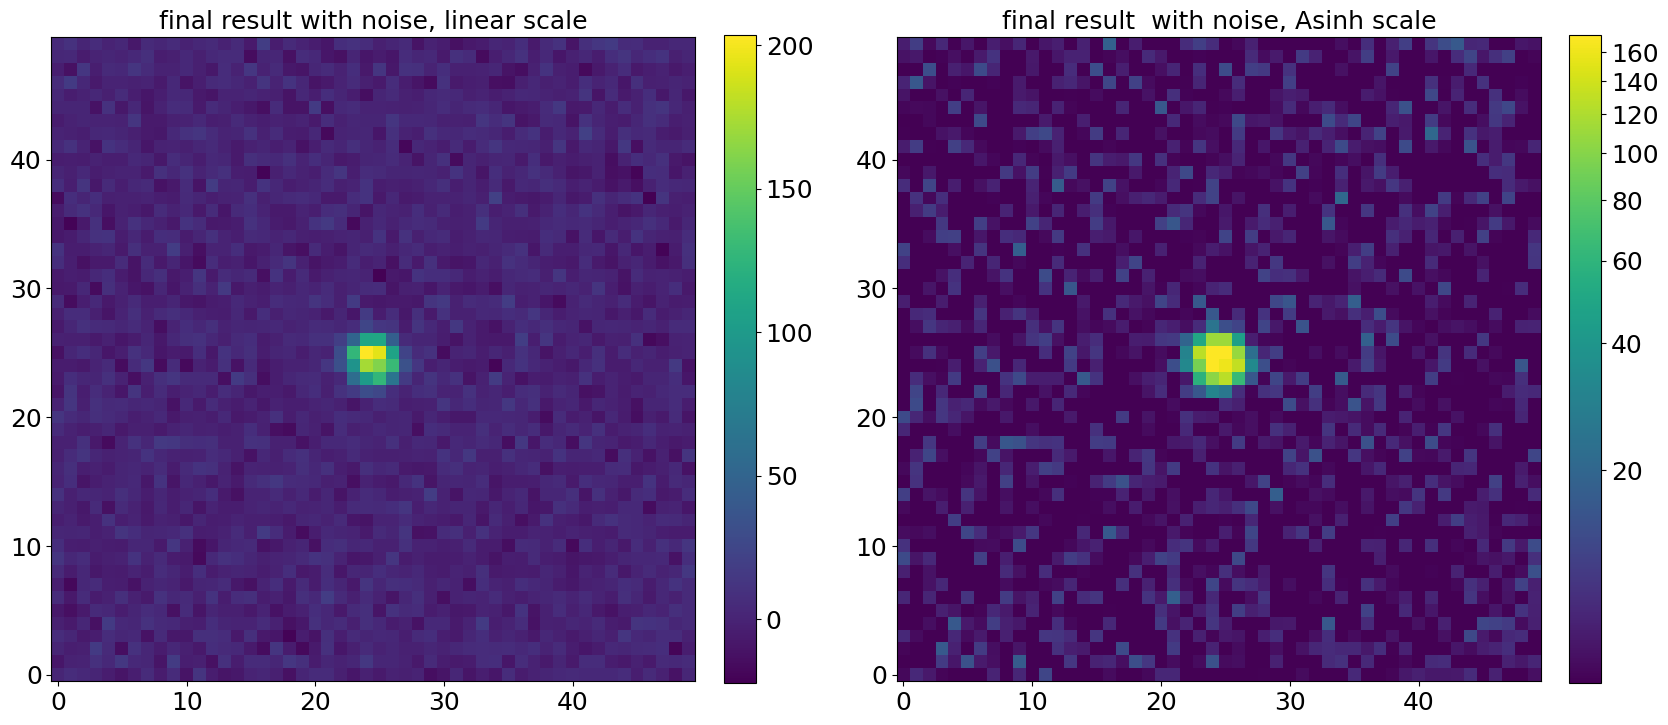

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(optPsf_final+artifical_noise_data,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('final result with noise, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_final+artifical_noise_data,origin='lower',norm=norm)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('final result  with noise, Asinh scale', fontsize=18)        



# Few Images showing how optical PSF results change when changing parameters

## Adding defocus (Z4)

In the examples below, we have removed all the other abberations so that we can more clearly see the difference when adding specific abberations

In [20]:
allparameters_proposal=np.array([12,0,0,0,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])

model(allparameters_proposal)

/projects/HSC/PFS/stack/20220525/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


(-2297.346333011682, array([11.50001989, -1.50000579]))

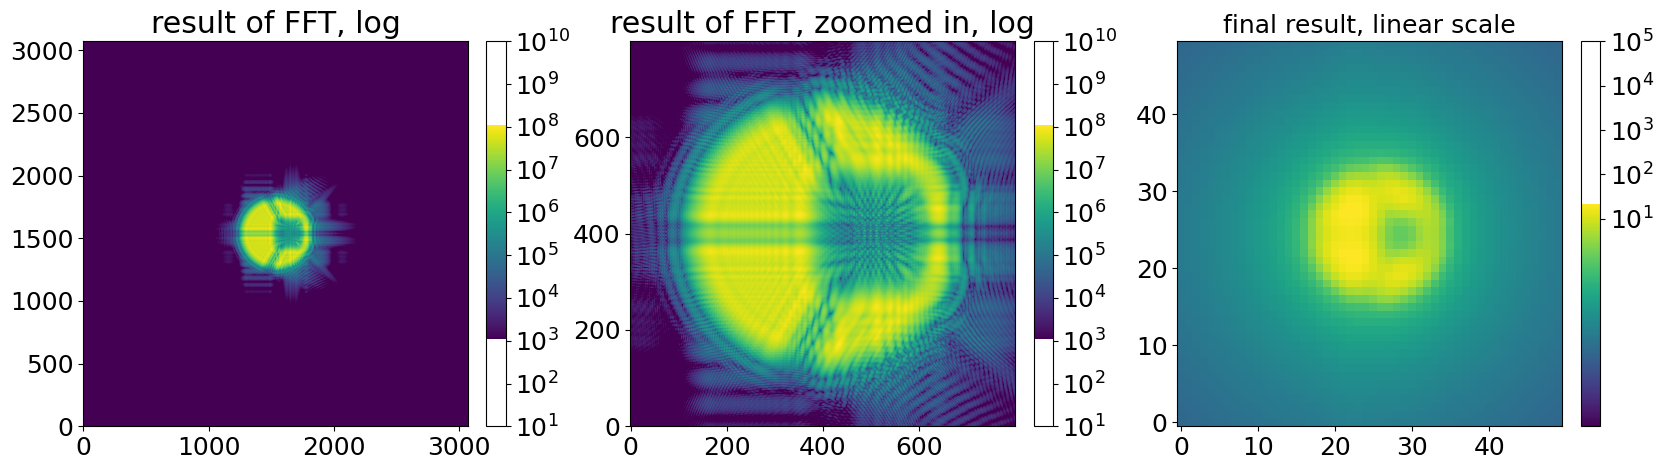

In [21]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
optPsf_final=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_final.npy')   

middleposition=int(optPsf.shape[0]/2)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(optPsf,origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(132)
plt.imshow(optPsf[middleposition-400:middleposition+400,middleposition-400:middleposition+400],
           origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

plt.subplot(133)
plt.imshow(optPsf_final,origin='lower', norm=LogNorm(vmax=np.max(optPsf_final),vmin=np.max(optPsf_final)/10**5))

plt.title('final result, linear scale', fontsize=18)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## Adding astigmatism (Z5 and Z6)

In [22]:
allparameters_proposal=np.array([0,1,0,0,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])

model(allparameters_proposal)

(-2297.346333011682, array([-0.49999999,  0.4375209 ]))

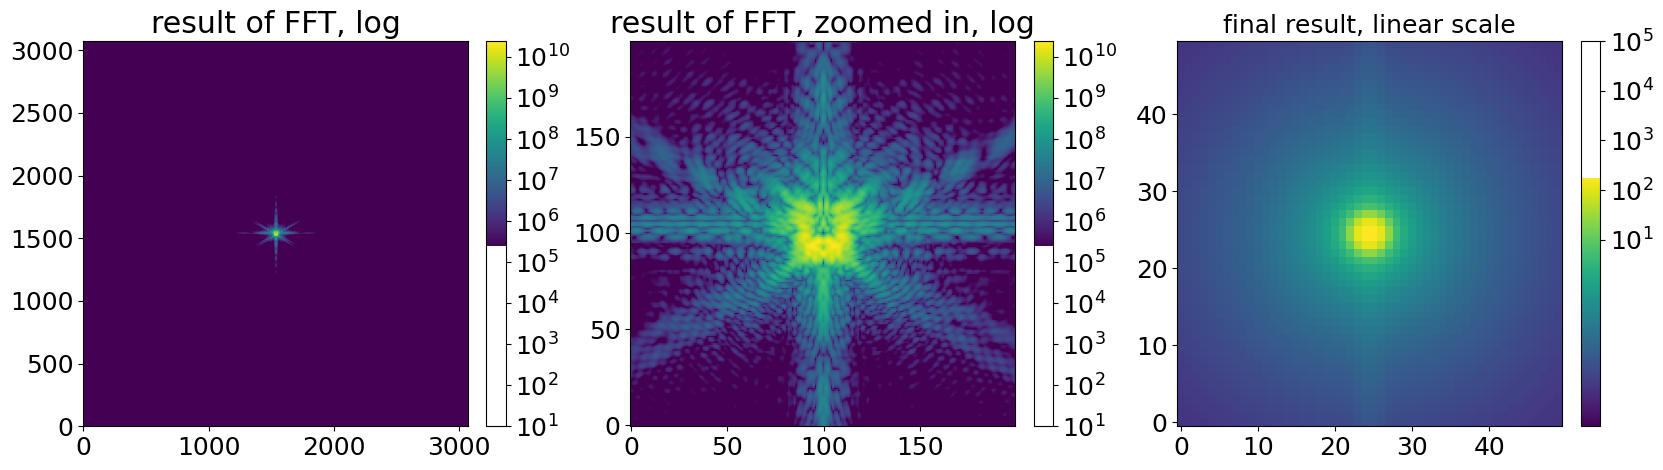

In [23]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
optPsf_final=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_final.npy')   

middleposition=int(optPsf.shape[0]/2)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(optPsf,origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(132)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],
           origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

plt.subplot(133)
plt.imshow(optPsf_final,origin='lower', norm=LogNorm(vmax=np.max(optPsf_final),vmin=np.max(optPsf_final)/10**5))

plt.title('final result, linear scale', fontsize=18)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## Adding coma (Z7 and Z8)

In [24]:
allparameters_proposal=np.array([0,0,0,1,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

(-2297.346333011682, array([-0.50001021, -0.49999825]))

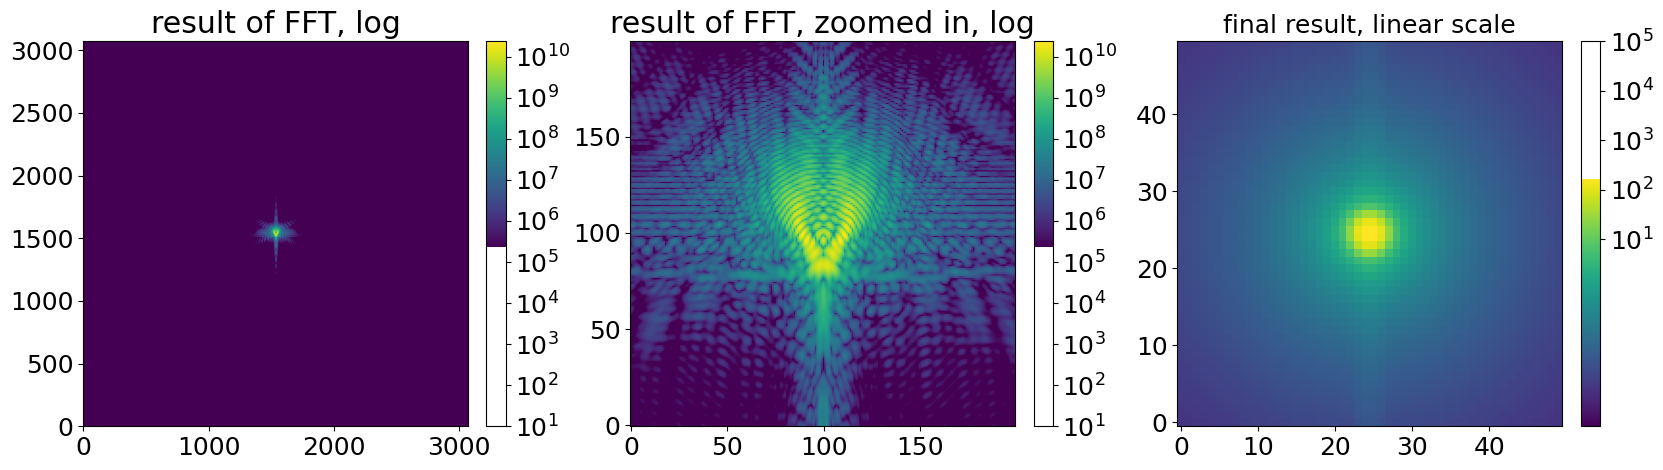

In [25]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
optPsf_final=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_final.npy')   

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(optPsf,origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(132)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

plt.subplot(133)
plt.imshow(optPsf_final,origin='lower', norm=LogNorm(vmax=np.max(optPsf_final),vmin=np.max(optPsf_final)/10**5))

plt.title('final result, linear scale', fontsize=18)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## Adding trefoil (Z9 and Z10)

In [26]:
allparameters_proposal=np.array([0,0,0,0,0,1,1,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])

model(allparameters_proposal)

(-2297.346333011682, array([-0.50000001, -0.48655826]))

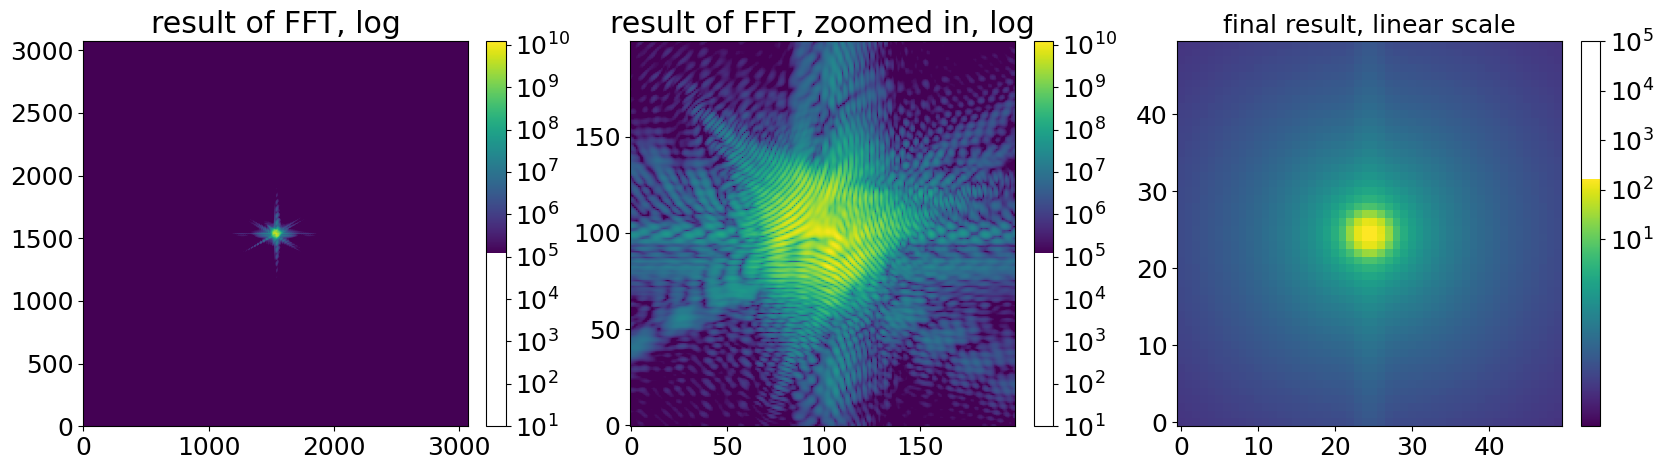

In [27]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
optPsf_final=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_final.npy')   
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(optPsf,origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(132)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

plt.subplot(133)
plt.imshow(optPsf_final,origin='lower', norm=LogNorm(vmax=np.max(optPsf_final),vmin=np.max(optPsf_final)/10**5))
plt.title('final result, linear scale', fontsize=18)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

# Comparison with real data 

In this section we will look at some real data taken with the spectrograph, and see how the model connects with the data

In [28]:
# First we load files that give us information about where the poststamp images are avaliable.

finalAr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalAr_Jul2021",allow_pickle=True)
finalNe=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalNe_Jul2021",allow_pickle=True)
finalKr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalKr_Jul2021",allow_pickle=True)

finalAr[0:5]

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,650,69,808,690.9346,0,HgAr,69,-19.25,0.0034,-40.7,0.006
1,650,69,875,696.7261,1,Ar,69,0,0,0,0
2,650,70,992,706.8989,0,Ar,70,-39.597,0.0143,0.0,0.0
3,650,71,1229,727.47876,1,Ar,71,0,0,0,0
4,650,72,1358,738.6248,0,Ar,72,-13.14,0.011,0,0


In [29]:
# We then load the files that contain solutions at various locations specified above
DATAFRAMES_FOLDER='/tigress/ncaplar/PFS/Fit_Results/Sep0521/'
    
results_of_fit_many_Ar_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Ne_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Kr_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Sep0521.pkl',allow_pickle=True)

In [30]:
# We then need to load the poststamp images
STAMPS_FOLDER = '/tigress/ncaplar/ReducedData/Data_Nov_20/Stamps_cleaned/'

# obs refer to the visit_id of the exposure
obs = 34341
# this is the index of the spot that we are loading, which is described in the dataframe finalAr above
single_number = 55
# which arcline are we observing
arc = 'Ar'
# wavelength at which the observation has been done
wavelength=float(finalAr.loc[int(single_number)]['wavelength'])

sci_image = np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image = np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
mask_image = np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [31]:
# to create the model image we also need to load the parameters
# 'm4' referes to the fact that the data have been taken with slit being moved to -4 mm for these exposures
allparameters_full = results_of_fit_many_Ar_Sep0521['m4'].loc['55']

parameters = allparameters_full[:-2]
parameters.values

array([   28.87760121,    -0.54037837,    -0.98099124,     0.14361402,
          -0.05561737,    -0.12787079,    -0.27154296,    -0.51173872,
          -0.03761219,     0.00516992,     0.00819949,     0.02842661,
          -0.02136718,     0.0547658 ,    -0.01138433,    -0.00440926,
          -0.02574699,     0.03086103,     0.05147144,     0.65704037,
           0.07      ,    -0.03366242,     0.04002791,     0.06041261,
           0.00593532,     0.14306274,     0.1689575 ,     0.26369814,
           0.71985536,     0.01819063,    -0.06378628,     0.92345109,
           0.03944312,     0.85065152,     1.02438916,     0.17409216,
       29485.315812  ,     2.33177004,     0.00184866,     0.32549148,
           1.81026247,     0.99973519,    -0.00442064,     0.00966725,
           0.00097421,    -0.00297854,     0.00225425,     0.00074838,
          -0.00107408,     0.00092663,    -0.00195254,     0.00116681,
           0.00062716,     0.00365944,    -0.0042067 ,    -0.00523219,
      

In [32]:
# we passed additional parameter `zmax=56`, that indicates that we go to 56th Zernike order
model = LN_PFS_single(sci_image=sci_image, var_image=var_image, mask_image=mask_image, zmax=56, save=1, wavelength = wavelength)   
res=model(parameters, return_Image=True)
model_image = res[1]

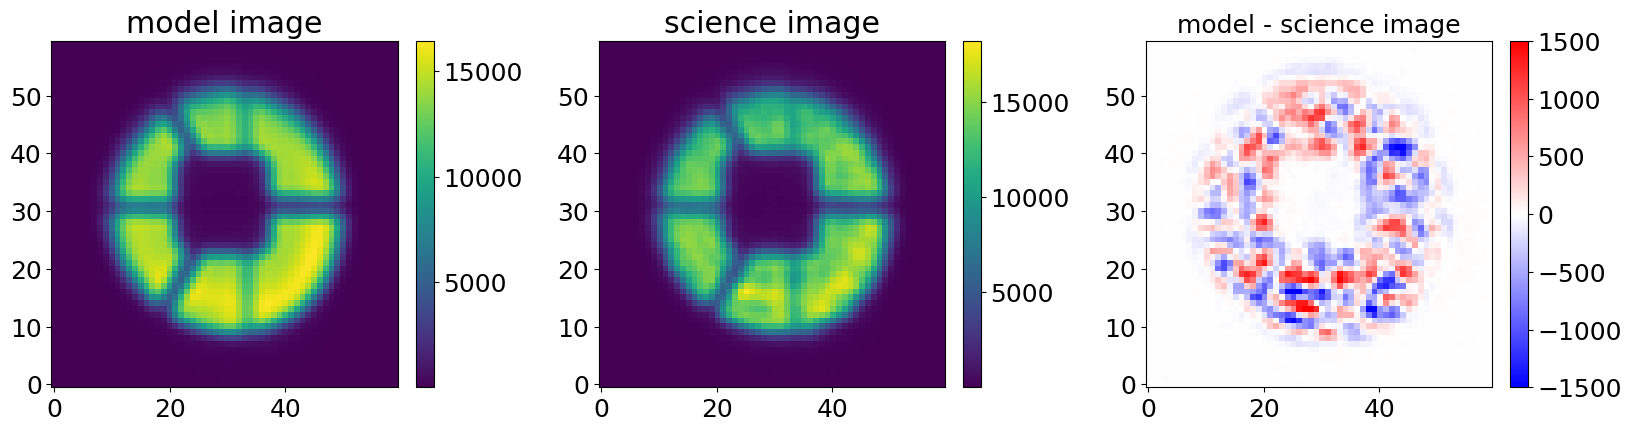

In [33]:
plt.figure(figsize=(20,4.5))
plt.subplot(131)
plt.imshow(model_image, origin = 'lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('model image')

plt.subplot(132)
plt.imshow(sci_image, origin = 'lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('science image')

plt.subplot(133)
plt.imshow(model_image - sci_image, origin='lower', cmap='bwr', vmin = -1500, vmax = +1500)

plt.title('model - science image', fontsize=18)
cbar=plt.colorbar(fraction=0.046, pad=0.04)